In this notebook we expand on the work in "Exploration 1", introducing many more noises and dropping some of the exploratory code. The same CNN proves quite effective, again, and we save a model for later use in real-time recognition.

# Data loading and cleaning

In [1]:
# load the audio files, and give each noise a label
# we'll assume each file contains multiple, spaced reptitions of the same noise
from pydub import AudioSegment
directory = "./recordings/sennheiser/"
noise_type_labels = ['t', 'p', 'k', 'ch',
                    'ts', 'ps', 'ks', 'chsh',
                    'tf', 'pf', 'kf', 'chf',
                    'forward-tsk', 'side-cluck', 'lip-open-pop']
noise_audio = { n: AudioSegment.from_file(directory + n + '1.m4a') for n in noise_type_labels }

# get some basic properties
frame_rate = { n: noise_audio[n].frame_rate for n in noise_audio }
print("Frame rates:", frame_rate)

# convert to mono, so each frame has only one sample
noise_audio_mono = { n: noise_audio[n].set_channels(1) for n in noise_audio }

# finally, convert to a more workable data type
import pandas as pd
noise_sample_array = {n: noise_audio_mono[n].get_array_of_samples() for n in noise_audio }
noise_series = { n: pd.Series(noise_sample_array[n], name=n) for n in noise_audio }

noises = pd.concat(noise_series.values(), axis=1)

Frame rates: {'t': 44100, 'p': 44100, 'k': 44100, 'ch': 44100, 'ts': 44100, 'ps': 44100, 'ks': 44100, 'chsh': 44100, 'tf': 44100, 'pf': 44100, 'kf': 44100, 'chf': 44100, 'forward-tsk': 44100, 'side-cluck': 44100, 'lip-open-pop': 44100}


In [2]:
# We may need these later
import numpy as np
import matplotlib.pyplot as plt

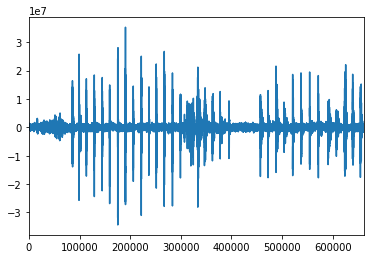

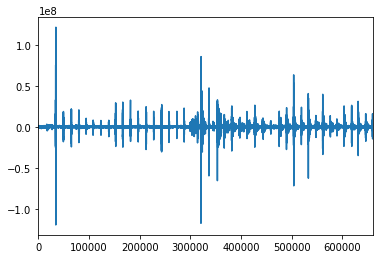

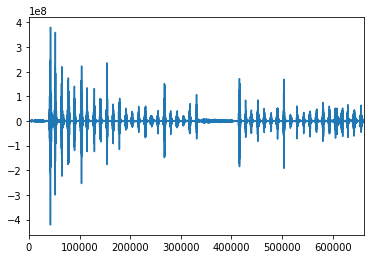

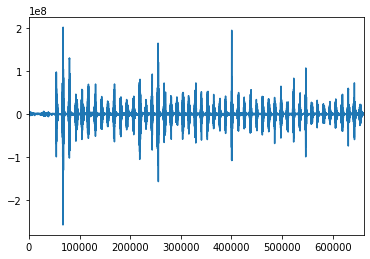

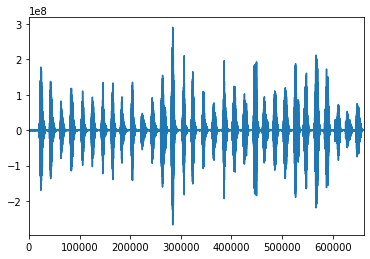

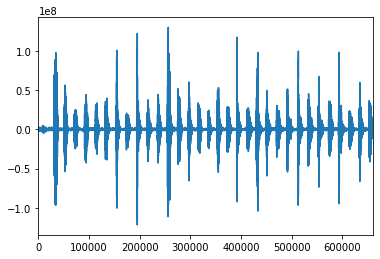

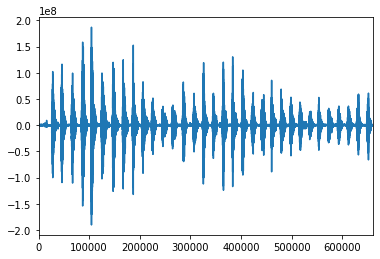

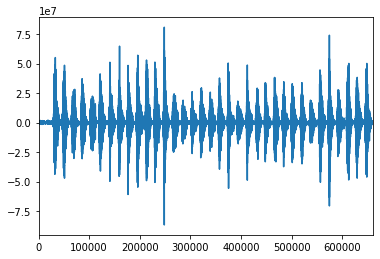

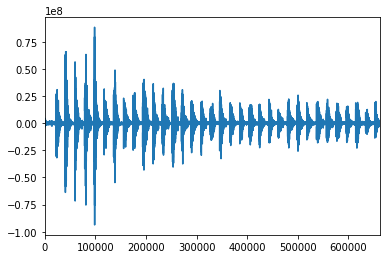

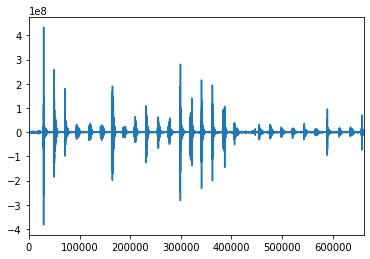

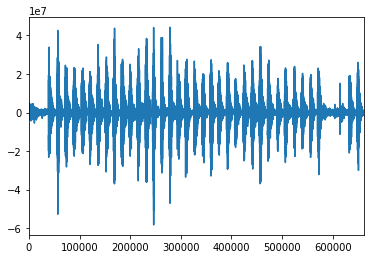

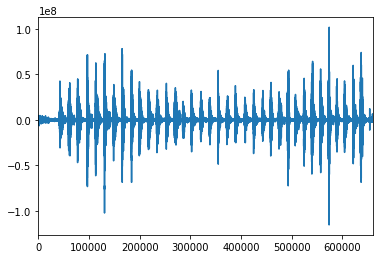

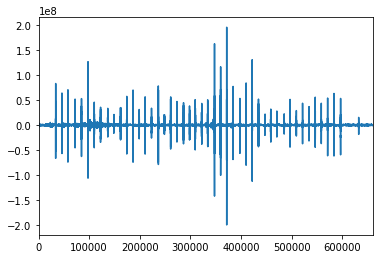

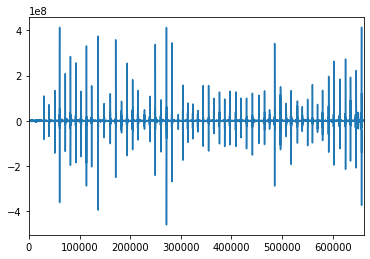

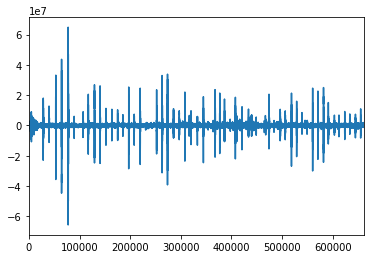

In [3]:
# visualize, to make sure things are sensible so far
length = 15 * frame_rate['t']
for n in noise_type_labels:
    plt.figure()
    noises[n][:length].plot()

We want to isolate each of these spikes from the recording automatically, as individual "observations" of the desired noise. To do so we need to estimate when each noise starts, and how long it lasts. We'll assume short, percussive noises for now (not drawn out, like a hisssss).

To find the spikes, then, let's scan and look for peaks in amplitude. We observed earlier that each spike lasts a few 10s of ms, so let's scan in batches of ~0.02 sec, looking for with the amplitude in one batch is substantially larger than the previous. This should also help to avoid loud but non-percussive noises (like a breath or word) that might otherwise clutter the data.

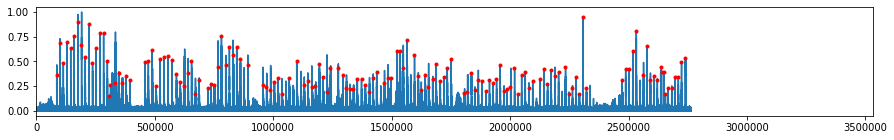

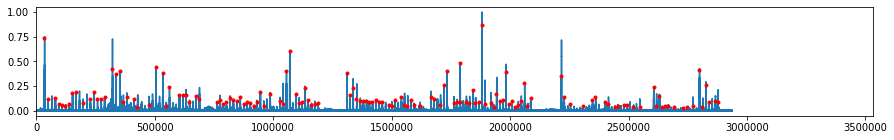

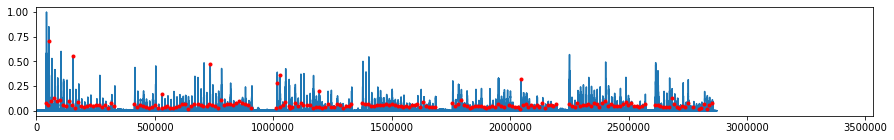

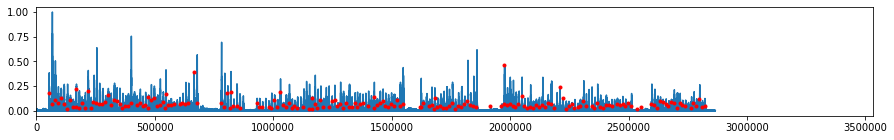

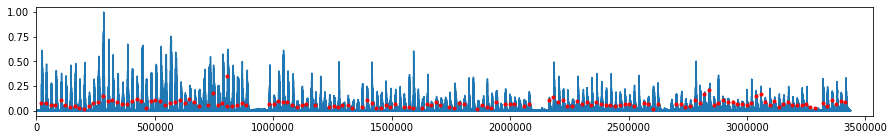

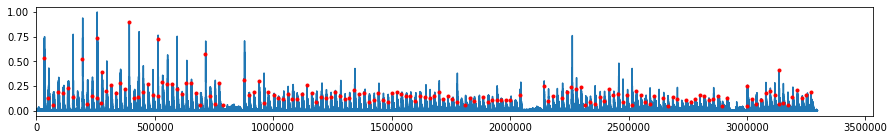

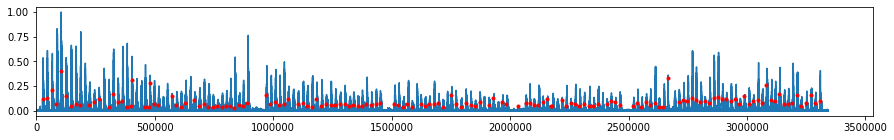

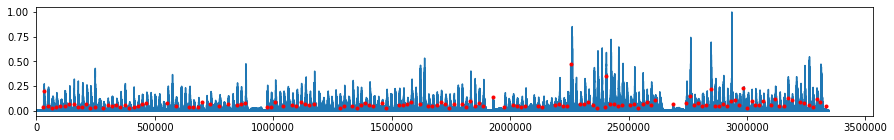

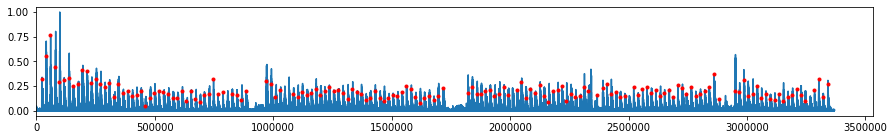

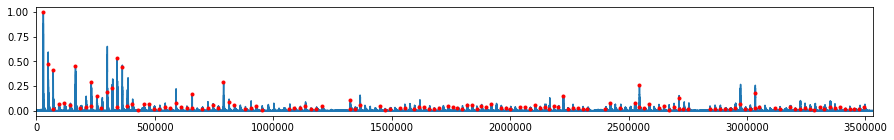

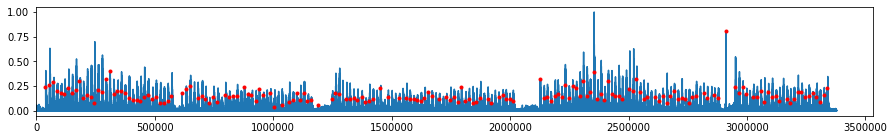

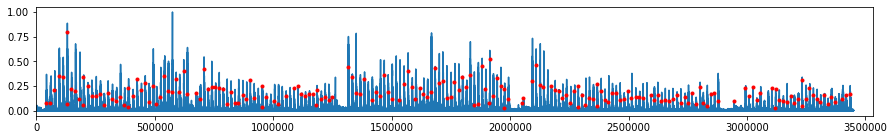

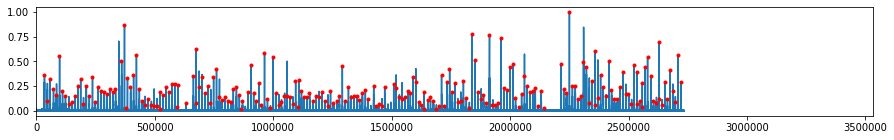

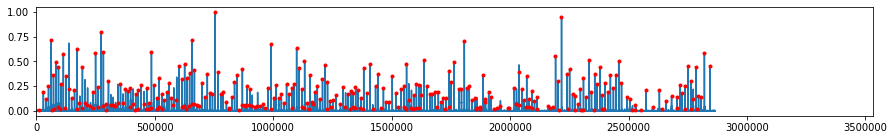

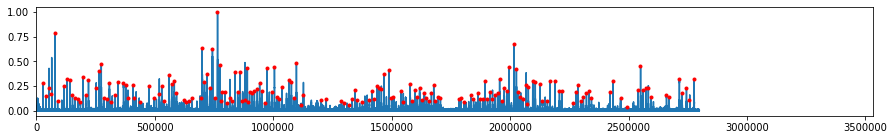

In [5]:
BATCH_DURATION = 0.02 # look at BATCH_DURATION (seconds) at a time
THRESHOLD_MULTIPLIER = 5 # detect a spike when the next batch is at least THRESHOLD_MULTIPLIER times bigger

spike_locations  = { n: [] for n in noises }
spike_amplitudes = { n: [] for n in noises }
for n in noises:
    data  = noises[n].apply(abs)
    data /= data.max() # normalize
    batch_size = round(BATCH_DURATION * frame_rate[n])
    number_of_batches = len(data) // batch_size
    
    last_amplitude = 1 # initialize variable
    for b in range(number_of_batches):
        start = batch_size * b
        end   = batch_size * (b + 1)
        amplitude = data[start:end].max()
        if amplitude > THRESHOLD_MULTIPLIER * last_amplitude:
            spike_locations[n].append(start)
            spike_amplitudes[n].append(amplitude)
        last_amplitude = amplitude
    
    # visualize the spike locations
    plt.figure(figsize=(15,2))
    data.plot()
    for i in range(len(spike_locations[n])):
        x = spike_locations[n][i]
        y = spike_amplitudes[n][i]
        plt.plot([x], [y], marker='o', markersize=3, color="red")


At least by visual inspection, this seems to have caught most volume spikes relatively well---or at least, the number of dots seems to roughly line up with the number of visual spikes. How many spikes did we find for each?

In [7]:
print({ n: len(spike_locations[n]) for n in spike_locations })

{'t': 146, 'p': 142, 'k': 210, 'ch': 195, 'ts': 150, 'ps': 153, 'ks': 152, 'chsh': 140, 'tf': 158, 'pf': 140, 'kf': 175, 'chf': 196, 'forward-tsk': 221, 'side-cluck': 308, 'lip-open-pop': 181}


It seems we recorded in anomalously large number of side-cluck's, and also a lot of k's and forward-tsk's. We should be careful to check that this doesn't bias the training too much later, and may need to even out these numbers. We could do this easily either by augmenting the data for the less numerous noises, or truncating the number of overabundant noises used for training.

Let's now grab a window around each spike, that we'll use for analysis and training. This will create one dataframe per isolated noise. We'll also normalize them while we're at it, to have the same average amplitude.

We note that to capture the bulk of most of these noises, we really need to go out to 0.08-0.10s after each spike location. We don't want to wait too long, however, because ultimately we hope to do this in real-time. Let's try keeping it to 3 * BATCH_DURATION = 0.06s after the spike location, like we did in Exploration 1, to see how well the training can do with just the percussive start of each noise.

(Update: It did quite well (~93% accuracy), but ran into occasional confusions with various ch sounds, and occasionally misrecognized side-clucks for forward-tsks. Let's try bumping up to 0.08s to see how that performs.)

(Update 2: 0.08s yields a slight improvement, up to ~95% accuracy. 0.10s brings it up to ~96%. The most common single errors remain the side-cluck's, but this is likely just a statistical quirk, since they are substantially overrepresented in the testing set.)

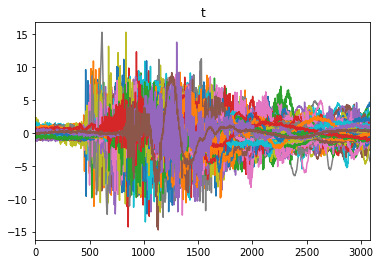

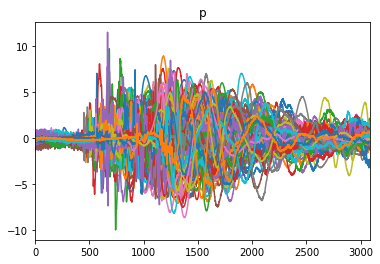

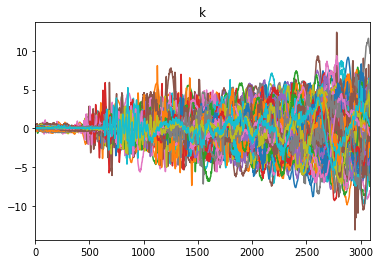

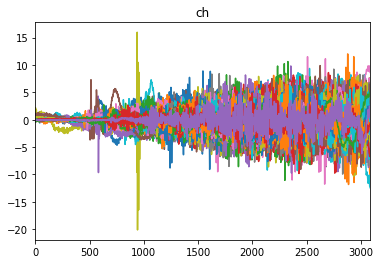

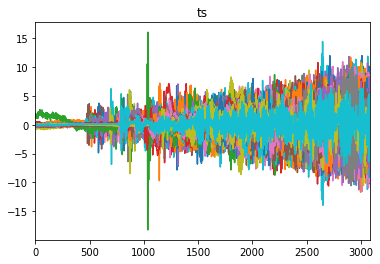

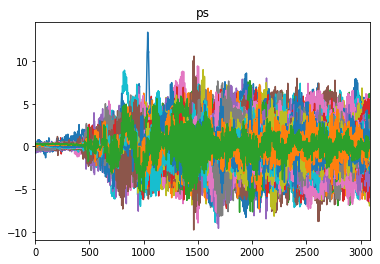

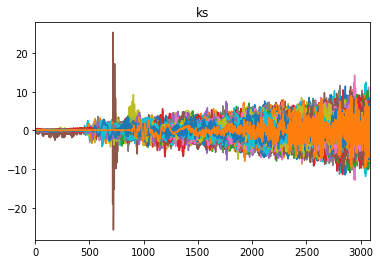

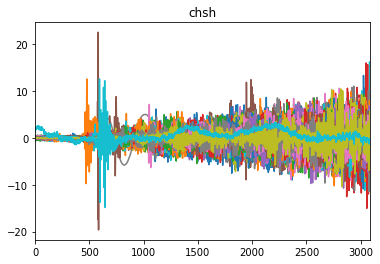

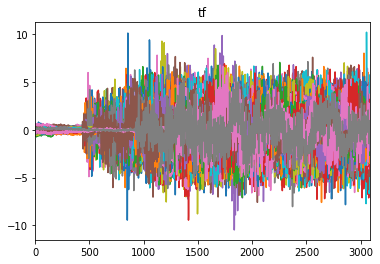

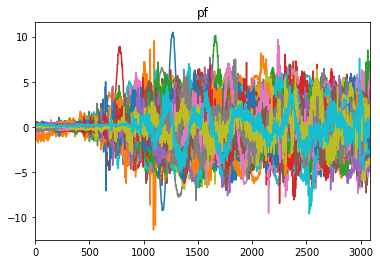

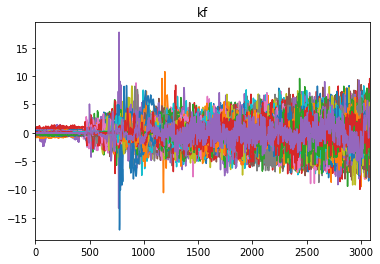

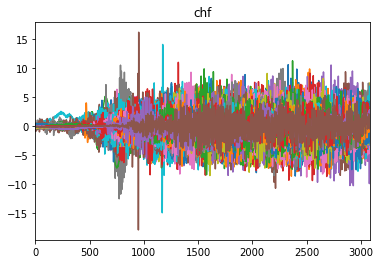

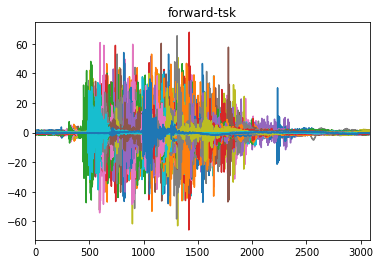

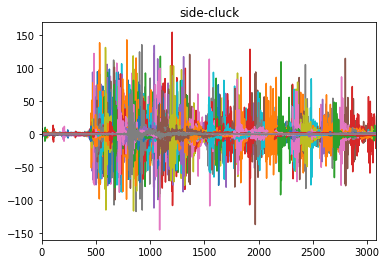

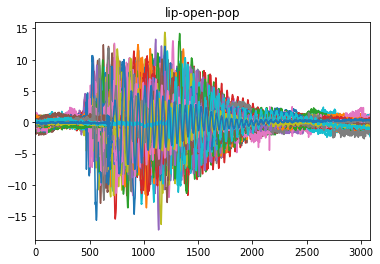

In [237]:
BEFORE = 0.5 * BATCH_DURATION # the time (sec) to look before the spike location
AFTER  = 3 * BATCH_DURATION # the time (sec) to look after the spike location

noises_isolated = {}

def normalize(series):
    mean = series.apply(abs).mean()
    return series / mean

for n in noises:
    df = pd.DataFrame()
    b = round(BEFORE * frame_rate[n])
    a = round(AFTER  * frame_rate[n])
    LABEL = '_obs'
    for s in spike_locations[n]:
        obs = noises[n].iloc[ s-b : s+a ].reset_index(drop=True)
        df[n + LABEL + str(s)] = normalize(obs)
    
    noises_isolated[n] = df
    noises_isolated[n].plot(legend=False, title=n)

These observations are all the same length, and have no missing data. This is dependent on two things: 
* the before and after intervals were identical because the frame rates were identical (different frame rates might yield off by one differences because of rounding)
* the spikes are all sufficiently displaced from the ends of the data that there is always enough data to grab a full before and after interval

The former we could control by matching all the frame rates before proceeding. The latter will be important for training anyways, so we can instruct users to leave enough quiet space at the beginning and ends of the recordings. This will not be hard, because we only need 32ms per observation.

In [238]:
# There is no missing data
[ noises_isolated[n].isnull().any().any() for n in noises ]

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

Let's listen to the samples, to see if they sound reasonable. Overall, pretty good. There are a small few audio outliers in each noise type, but the spike capturing method above seems to have generalized well to the new sounds. Some of the combo sounds (e.g., tf and chsh, and maybe even side-cluck) might not have been sufficiently captured by the small window chosen. We might need to either abandon them or allow a bigger window to distinguish similar sounds (e.g., ch vs. chsh).

As in Exploration 1, we note there will be variation based on the microphone and microphone position used, so we should keep an eye on this when generalising to other mics later.

In [239]:
import sounddevice as sd

for n in noises:
    if n in []: # list here the noises you want to hear
        print(n)
        fr = frame_rate[n]
        for obs_label, obs_data in noises_isolated[n].iteritems():
            sd.play(obs_data / obs_data.max() / 10, fr)
            sd.wait()

# Classification by spectrograms

To classify these, we will compute their spectrograms and classify the resulting images. To begin, we will use Mel Spectrograms (which show more distinct features), and a Convolutional Neural Net (CNN) to classify them, since CNN's have shown particular success in image classification. We will use PyTorch for both of these tasks. (Ultimately we might wish to use PyTorch for the original audio processing, as well.)

This approach worked well for just two noises, 't' and 'p'. Let's see how well it generalizes to our new noise zoo.

In [240]:
import torch
import torchaudio

Let's compute the mel spectrograms for all of our samples. Let's also take note of how long it takes, since eventually we'll want to do this or something similar in real-time. We note it seems that the runtime is independent of n_mels, the number of mel filterbanks in the spectrogram.

In [241]:
import time

start = time.time()

noise_spectrograms = { n: [] for n in noises }
n_mels = 28
for n in noises:
    fr = frame_rate[n]
    for obs_label, obs_data in noises_isolated[n].iteritems():
        obs_data = torch.tensor(obs_data)
        mel = torchaudio.transforms.MelSpectrogram(
            sample_rate=fr, n_mels=n_mels)(obs_data)
        noise_spectrograms[n].append(mel.log2())
        
end = time.time()
total_time = end - start
n_samples = sum([ len(df.columns) for n, df in noises_isolated.items() ])
avg_time = total_time / n_samples

print("The total time elapsed is", total_time, "sec.")
print("The average time per spectrogram is", avg_time, "sec.")

The total time elapsed is 78.87828397750854 sec.
The average time per spectrogram is 0.02957565953412394 sec.


# Preparing the datasets

Now, let's move on to building and training a model. First we build our dataset. Ultimately we may wish for this dataset class to also do all of the preprocessing we've done above, but for now we'll just use the spectrograms we've made. The simple dataset class here is adapted from https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel.

For training, it may also be helpful to augment our data by randomly shifting the window around each volume spike. We'll leave that for another time, though.

In [242]:
from torch.utils.data import Dataset, DataLoader
            
class NoisesDataset(Dataset):
    """Noises dataset."""

    def __init__(self, spectrograms, labels): 
        'Initialization'
        self.spectrograms = spectrograms
        self.labels = labels

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.labels)

    def __getitem__(self, sample_index):
        'Generates one sample of data'
        # Load data and get label
        # Note the CNN will expect the first tensor dimension to be the channel, hence the unsqueeze
        X = self.spectrograms[sample_index].unsqueeze(0)
        y = self.labels[sample_index]

        return X, y

We split into training and testing data sets, adapted from https://stackoverflow.com/questions/53916594/typeerror-object-of-type-numpy-int64-has-no-len

We observed earlier that we have very different numbers of samples for different kinds of noises. To avoid biasing the network towards the overrepresented noises, let's jump through a couple hoops to make the noise types fairly evenly represented in the training dataset.

In [243]:
# Here are the sample counts
sample_counts = { n: len(noise_spectrograms[n]) for n in spike_locations }
print(sample_counts)
sample_counts_series = pd.Series(list(sample_counts.values()))
sample_counts_series.describe()

{'t': 146, 'p': 142, 'k': 210, 'ch': 195, 'ts': 150, 'ps': 153, 'ks': 152, 'chsh': 140, 'tf': 158, 'pf': 140, 'kf': 175, 'chf': 196, 'forward-tsk': 221, 'side-cluck': 308, 'lip-open-pop': 181}


count     15.000000
mean     177.800000
std       44.798278
min      140.000000
25%      148.000000
50%      158.000000
75%      195.500000
max      308.000000
dtype: float64

Let's take 80% of each noise type for the training set, unless that is larger than the median sample number, in which case we'll limit to the median. Will build training and testing data sets for each noise type, and then join them together using torch.utils.data.ConcatDataset(datasets).

A caution: After training this model with various random datasets using this method, it seems clear that some of the side-cluck samples are higher quality than others. There is noticeable variation in the number that are misrecognized for forward-tsk's.

The better way to address the overrepresentation is probably to use a weighted random sampler. We'll come back to that another time.

In [244]:
training_fraction = 0.8
sample_counts = { n: len(noise_spectrograms[n]) for n in noise_spectrograms }
median_sample_count = int(sample_counts_series.median())

full_dataset  = NoisesDataset([], [])
train_dataset = NoisesDataset([], [])
test_dataset  = NoisesDataset([], [])

# We'll convert the noise type labels to integers as we go, and record the mappings here
noise_int_to_str, i = {}, 0

# Iterate over each noise type, building up the training and testing datasets
for n in noise_spectrograms:
    noise_int_to_str[i] = n
    
    train_size = int(training_fraction * sample_counts[n])
    if train_size > median_sample_count:
        train_size = median_sample_count
    test_size = sample_counts[n] - train_size
    
    n_dataset = NoisesDataset(noise_spectrograms[n], [i] * sample_counts[n])
    n_train_dataset, n_test_dataset = torch.utils.data.random_split(n_dataset, [train_size, test_size])
    
    full_dataset  = torch.utils.data.ConcatDataset([full_dataset,  n_dataset])
    train_dataset = torch.utils.data.ConcatDataset([train_dataset, n_train_dataset])
    test_dataset  = torch.utils.data.ConcatDataset([test_dataset,  n_test_dataset])
    
    i += 1

# Build the data loaders with the final datasets
train_params = {
    'batch_size': 10,
    'shuffle': True,
    'num_workers': 1,
}
train_loader = DataLoader(dataset=train_dataset, **train_params)
test_loader  = DataLoader(dataset=test_dataset)

Let's also check what balance we achieved in the training set, just to make sure there's a reasonably even number of different types of noise.

In [245]:
def count_noise_types_in_dataset(dataset):
    counts = {}
    for s, n_int in dataset:
        try:
            counts[n_int] += 1
        except:
            counts[n_int] = 1
    return { noise_int_to_str[k]: v for k, v in counts.items() }

print(count_noise_types_in_dataset(train_dataset))
print(count_noise_types_in_dataset(test_dataset))

{'t': 116, 'p': 113, 'k': 158, 'ch': 156, 'ts': 120, 'ps': 122, 'ks': 121, 'chsh': 112, 'tf': 126, 'pf': 112, 'kf': 140, 'chf': 156, 'forward-tsk': 158, 'side-cluck': 158, 'lip-open-pop': 144}
{'t': 30, 'p': 29, 'k': 52, 'ch': 39, 'ts': 30, 'ps': 31, 'ks': 31, 'chsh': 28, 'tf': 32, 'pf': 28, 'kf': 35, 'chf': 40, 'forward-tsk': 63, 'side-cluck': 150, 'lip-open-pop': 37}


This looks like a very reasonable balance, though the testing dataset is accordingly unbalanced.

Let's observe a few of the data, to make sure all is in order

   p forward-tsk   ks    k   kf    p forward-tsk    t forward-tsk   tf


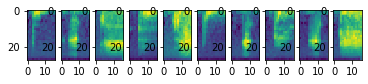

In [246]:
# get some random training spectrograms
train_dataiter = iter(train_loader)
spectrograms, labels = train_dataiter.next()
batch_size = train_params['batch_size']

# show spectrograms
fig, ax = plt.subplots(1, batch_size)
for i in range(len(spectrograms)):
    if batch_size == 1:
        ax.imshow(spectrograms[i][0].numpy()) # the 0 selects the first (only) channel
    else:
        ax[i].imshow(spectrograms[i][0].numpy()) # the 0 selects the first (only) channel

# print labels
print(' '.join('%4s' % noise_int_to_str[labels[j].item()] for j in range(batch_size)))

Finally, before we move on to the CNN, let's check the resolution of each spectrogram, and confirm it's the same for all.

In [247]:
image_size = full_dataset[0][0].size() # first image of first batch
for s, l in full_dataset:
    if s.size() != image_size:
        print("Image size does not match.")

print(image_size)

torch.Size([1, 28, 16])


# Preparing the CNN

Much of this section is adapted from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py.

Let's begin by trying two convolution layers, and three dense layers.

In [248]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, image_size):
        super(Net, self).__init__()
        
        # image_size is a 2-tuple, the expected dimensions of each spectrogram
        channels, h, w = image_size
        
        # number of output nodes, (square) kernel size, and pool size per convolution layer,
        # assuming the stride for pooling is the same as the pool size
        kernels = [3, 3]
        pool = 2
        
        # compute the number of input nodes for the first dense layer
        h_out, w_out = h, w
        for k in kernels:
            # the convolution.
            h_out += -k + 1
            w_out += -k + 1
            
            # the pool. (from help(torch.nn.MaxPool2d))
            h_out = int( (h_out - pool) / pool + 1 )
            w_out = int( (w_out - pool) / pool + 1 )
            
        self.image_out = h_out * w_out
        
        # number of output nodes for final dense layer: the number of noise types
        N_noises = len(noise_int_to_str) # the total number of noise types
        
        # define the layers. The numbers of nodes chosen do not have deep thought behind them.
        self.conv0 = nn.Conv2d(1, 32, kernels[0])
        self.pool = nn.MaxPool2d(2)
        self.conv1 = nn.Conv2d(32, 10, kernels[1])
        self.fc0 = nn.Linear(10 * self.image_out, 50)
        self.fc1 = nn.Linear(50, 10)
        self.fc2 = nn.Linear(10, N_noises)

    def forward(self, x):
        x = self.pool(F.relu(self.conv0(x)))
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 10 * self.image_out)
        x = F.relu(self.fc0(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    
net = Net(image_size)

Let's check the parameter and sample counts.

In [249]:
print("There are %d parameters." % (
    sum([ p.numel() for p in net.parameters() ])))
print("There are %d data samples." % (len(full_dataset)))

There are 8935 parameters.
There are 2667 data samples.


Does the net accept our data, as we hope?

In [250]:
for data in train_loader:
    inputs, labels = data
    try:
        net(inputs)
        print('All is well!')
    except:
        # Try again so we can see the errors
        print(net(inputs))
    break

All is well!


Here's our training code, set to update us on the running loss every batch_progress batches.

In [251]:
def train_net(net, epochs, batch_progress=50):
    batch_num = 0
    for epoch in range(epochs):  # loop over the dataset multiple times
        
        batch_running_loss = 0.0
        
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # accrue loss for printing
            batch_running_loss += loss.item()
            
            if batch_num % batch_progress == batch_progress-1:
                print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, batch_running_loss / batch_progress))
                batch_running_loss = 0.0
                batch_num = 0
            
            batch_num += 1
        
    print('Finished Training')

Now we need to define a cost function, and an optimizer to determine how our net should learn.

For cost, we'll choose CrossEntropyLoss, which particularly penalizes high confidence in wrong answers. 

For an optimizer, we'll go with Adam, which brings with it sane defaults.

Now we set these, make a fresh net, and train:

In [252]:
import torch.optim as optim

net = Net(image_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

train_net(net, 100, batch_progress=1000)

[5,   192] loss: 0.088
[10,   181] loss: 0.051
[15,   170] loss: 0.033
[20,   159] loss: 0.024
[25,   148] loss: 0.021
[30,   137] loss: 0.014
[35,   126] loss: 0.016
[40,   115] loss: 0.006
[45,   104] loss: 0.004
[50,    93] loss: 0.003
[55,    82] loss: 0.003
[60,    71] loss: 0.003
[65,    60] loss: 0.001
[70,    49] loss: 0.000
[75,    38] loss: 0.000
[80,    27] loss: 0.001
[85,    16] loss: 0.000
[90,     5] loss: 0.000
[94,   196] loss: 0.000
[99,   185] loss: 0.000
Finished Training


How does this perform on the testing data?

In [253]:
def accuracy_rating(dataloader, label):
    correct = 0
    total = 0
    all_targets = torch.tensor([], dtype=torch.long)
    all_predictions = torch.tensor([], dtype=torch.long)
    with torch.no_grad():
        for data in dataloader:
            spectrograms, labels = data
            outputs = net(spectrograms)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_predictions = torch.cat( 
                (all_predictions, predicted), dim=0 )
            all_targets = torch.cat( 
                (all_targets, labels), dim=0 )
            
    print('Accuracy of the network on the %d %s spectrograms: %d %%' % (
        total,
        label,
        100 * correct / total))
    
    return all_predictions, all_targets

accuracy_rating(train_loader, 'training')
preds, targets = accuracy_rating(test_loader, 'test')

Accuracy of the network on the 2012 training spectrograms: 100 %
Accuracy of the network on the 655 test spectrograms: 94 %


Very nice. It doesn't even seem to have overfit, and we didn't even need to augment the data.

Let's create a confusion matrix to see where the model struggles. We will adapt some good sample code for making a pretty confusion matrix, which can be found here: https://deeplizard.com/learn/video/0LhiS6yu2qQ

In [254]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


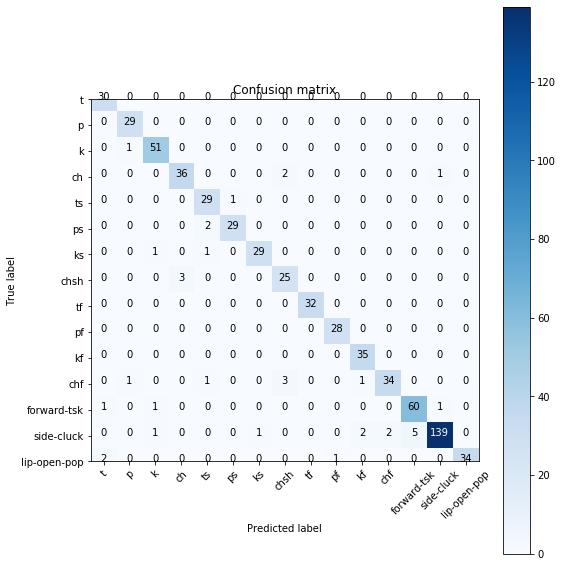

In [255]:
from sklearn.metrics import confusion_matrix

stacked = torch.stack( [targets, preds], dim=1 )
all_int_labels = sorted(list(set([ t.item() for t in targets ])))
num_labels = len(all_int_labels)
confusion_matrix = torch.zeros(num_labels, num_labels, dtype=torch.int64)

for pair in stacked:
    target_label, prediction_label = pair.tolist()
    confusion_matrix[target_label, prediction_label] += 1

cm_labels = [ noise_int_to_str[i] for i in all_int_labels ]
plot_confusion_matrix(confusion_matrix, cm_labels)

Unsurprisingly, it looks like most of the confusions involved ch and its variants, which are the longest sounds in the set. The only other common confusion seems to be that side-cluck's are occasionally misrecognized as forward-tsk's. It seems likely that these confusions would go away if we allowed the window to be a little bit bigger.

(Update: Increasing from 0.06s to 0.08s after each spike location increases accuracy from 93% to (up to) 95%, but adds ~30ms to real-time computation time: 0.02s from "waiting" after the spike, and another ~0.01s from the larger spectrogram.)

(Update 2: Increasing from 0.08s to 0.10s after each spike location increases accuracy from 95% to 96%, but adds yet another ~30ms to real-time computation time.)

Let's save the model, going back to 0.06s (after spike), which achieved 94% accuracy.

In [256]:
# PATH = './trained_models/14_noises_net1.pth'
# torch.save(net.state_dict(), PATH)